In [1]:
!pip install -q emoji

In [2]:
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import emoji
from matplotlib import pyplot

from utils_cbow import get_dict, get_batches, compute_pca

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
with open(r'shakespeare.txt') as f:
    file_ = f.read()

In [4]:
data = re.sub(r'[!?;,-]+' , '.' , file_)
data = word_tokenize(data)

data = [word.lower() for word in data if word.isalpha() or word == '.' or emoji.is_emoji(word)]

In [5]:
len(data)

61000

In [6]:
data[:10]

['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend']

In [7]:
# most 10 common words
Counter(data).most_common(10)

[('.', 9630),
 ('the', 1521),
 ('and', 1394),
 ('i', 1259),
 ('to', 1159),
 ('of', 1093),
 ('my', 857),
 ('that', 781),
 ('in', 771),
 ('a', 752)]

In [8]:
# words with corresponding indeces, i works like the vocab
word2Ind, Ind2word = get_dict(data)

len(word2Ind)

5784

In [9]:
print("words to indeces" , {k:v for k,v in list(word2Ind.items())[:5]})
print()
print("indeces to words" , {k:v for k,v in list(Ind2word.items())[:5]})

words to indeces {'.': 0, 'a': 1, 'abandon': 2, 'abed': 3, 'abhor': 4}

indeces to words {0: '.', 1: 'a', 2: 'abandon', 3: 'abed', 4: 'abhor'}


In [10]:
print("Index of the word 'king' :  ", word2Ind['king'] )
print("Word which has index 2743:  ", Ind2word[2743] )

Index of the word 'king' :   2747
Word which has index 2743:   kind


In [11]:
def get_one_hot_encoder(word , word2Ind):

    # a vector fill with zeros except the word index
    vec = np.zeros((len(word2Ind), 1))
    idx = word2Ind[word]
    vec[idx] = 1

    return vec

In [12]:
get_one_hot_encoder('a',word2Ind)

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [13]:
def get_mean_vector(word_context):

    context_vecs = []

    # word_context contains the center word and contex ex: ("to",["i", "want", "play"])
    word = word_context[0]
    context = word_context[1]

    word_vector = get_one_hot_encoder(word, word2Ind)

    for w in context:

        context_vecs.append(get_one_hot_encoder(w, word2Ind))

    # conpute the mean for context vectors that will be fed into nn as one vector
    context_vectors = np.mean(context_vecs, axis = 0)

    return word_vector, context_vectors

In [14]:
def get_windows(data, window_size):

    all_windows = []

    # skip first window_size words and last window_size words
    for i in range( window_size, len(data)-window_size ):

        center_word = data[i]
        context = data[i-window_size : i] + data[i+1 : i+1+window_size]
        all_windows.append((center_word,context))

    return all_windows

In [15]:
d = ['i', 'am', 'happy', 'because', 'i','am','learning']

windows = get_windows(d,2)

for i in windows:

    word_v, cont_v = get_mean_vector(i)
    print(f'context vector: \n{cont_v}')
    print()

context vector: 
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

context vector: 
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

context vector: 
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]



In [16]:
def initialize_model(N, V, random_seed = 1):

    np.random.seed(random_seed)

    # V is the vocab size, N is the hidden layer dimension
    W1 = np.random.rand(N, V)
    W2 = np.random.rand(V, N)

    b1 = np.random.rand(N, 1)
    b2 = np.random.rand(V, 1)

    return W1, W2, b1, b2

In [17]:
tmp_N = 4
tmp_V = 10

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N, tmp_V)

assert tmp_W1.shape == ((tmp_N, tmp_V))
assert tmp_W2.shape == ((tmp_V, tmp_N))

print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


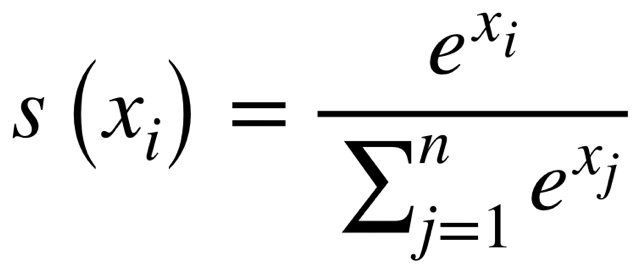

In [18]:
def softmax(z):

    numerator = np.exp(z)

    # the output is a column vector, so sum over axis 0 "columns"
    denumerator = np.sum(numerator, axis = 0)

    y_hat = numerator / denumerator

    return y_hat

In [19]:
tmp = np.array([[1,2,3],
                [1,1,1]])

tmp_softmax = softmax(tmp)
display(tmp_softmax)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

In [20]:
def relu(z):

    h = z.copy()
    h[h<0] = 0

    return h

In [21]:
# Forward propagation

def forward_prop(x, W1, W2, b1, b2):

    # W1 (N, V), x (V, 1), b1 (N, 1)
    z1 = np.dot(W1 , x) + b1
    h1 = relu(z1)

    # W2 (V, N), h1 (N, 1), b1 (V, 1)
    z2 = np.dot(W2 , h1) + b2

    return z2, h1

In [22]:
# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T # column vector

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N = tmp_N, V = tmp_V)

print(f"x has shape {tmp_x.shape}\n")
print(f"hidden dimension is {tmp_N} and vocabulary size V is {tmp_V}\n")

# call function
z_tmp, h_tmp = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)

print(f"z has shape {z_tmp.shape}")
print("z has values:")
print(z_tmp)

print()

print(f"h has shape {h_tmp.shape}")
print("h has values:")
print(h_tmp)

x has shape (3, 1)

hidden dimension is 2 and vocabulary size V is 3

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


**cross entropy loss function**



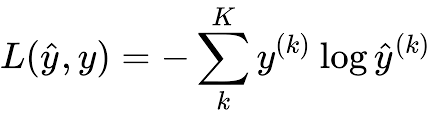

In [23]:
def compute_cost(y , y_hat, batch_size):

    # cross entropy loss
    logprobs = np.multiply( np.log(y_hat), y )
    cost = ( -1 / batch_size ) * np.sum(logprobs)

    return np.squeeze(cost)

In [25]:
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (5784, 4)
tmp_y.shape (5784, 4)
tmp_W1.shape (50, 5784)
tmp_W2.shape (5784, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5784, 1)
tmp_z.shape: (5784, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5784, 4)
call compute_cost
tmp_cost 11.8466


In [26]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):

    # Compute delta_h as W2^T (Yhat - Y)
    delta_h = np.dot(W2.T, (yhat - y))
    # Apply ReLU to delta_h
    delta_h = np.maximum(0, delta_h)

    # Compute the gradient of W1
    grad_W1 = (1 / batch_size) * np.dot(delta_h, x.T)
    # Compute the gradient of W2
    grad_W2 = (1 / batch_size) * np.dot(yhat - y, h.T)
    # Compute the gradient of b1
    grad_b1 = np.sum((1 / batch_size) * np.dot(delta_h, x.T), axis=1, keepdims=True)
    # Compute the gradient of b2
    grad_b2 = np.sum((1 / batch_size) * np.dot(yhat - y, h.T), axis=1, keepdims=True)

    return grad_W1, grad_W2, grad_b1, grad_b2

In [27]:
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5784, 4)
tmp_y.shape (5784, 4)

Initialize weights and biases
tmp_W1.shape (50, 5784)
tmp_W2.shape (5784, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5784, 1)

Forwad prop to get z and h
tmp_z.shape: (5784, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5784, 4)

call back_prop
tmp_grad_W1.shape (50, 5784)
tmp_grad_W2.shape (5784, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5784, 1)


In [28]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):

    # trainin process

    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2

    for x, y in get_batches(data, word2Ind, V, C, batch_size):

        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)

        # every 10 samples print the loss
        if ( (iters + 1) % 10 == 0 ):
            print(f"iters: {iters + 1} cost: {cost:.6f}")

        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)

        # Update weights and biases
        W1 -= alpha * grad_W1
        W2 -= alpha * grad_W2
        b1 -= alpha * grad_b1
        b2 -= alpha * grad_b2

        # for each sample increase iters by 1, and check if it reach the num_iters
        iters += 1
        if iters == num_iters:
            break

        # every 100 sample decrease the lr by 0.66
        if iters % 100 == 0:
            alpha *= 0.66

    return W1, W2, b1, b2

In [29]:
C = 2
N = 50

word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150

print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.054550
iters: 20 cost: 0.021306
iters: 30 cost: 0.013284
iters: 40 cost: 0.009659
iters: 50 cost: 0.007592
iters: 60 cost: 0.006255
iters: 70 cost: 0.005319
iters: 80 cost: 0.004627
iters: 90 cost: 0.004095
iters: 100 cost: 0.003673
iters: 110 cost: 0.003428
iters: 120 cost: 0.003224
iters: 130 cost: 0.003042
iters: 140 cost: 0.002880
iters: 150 cost: 0.002735


In [36]:
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2) / 2.0

# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]

print(X.shape, idx)

(10, 50) [2747, 3953, 2963, 3025, 5681, 1455, 5680, 4193, 2318, 4281]


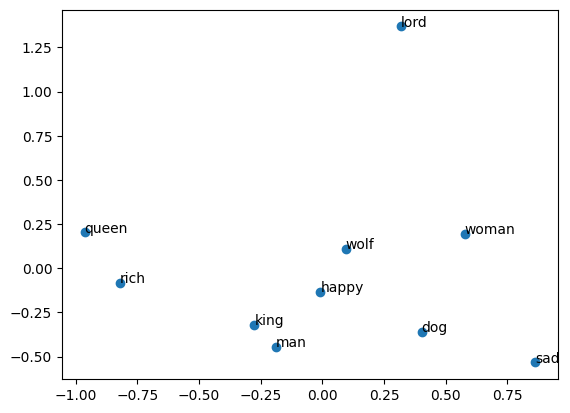

In [37]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()